# Exploring RNN architectures for Quantum state representation

A couple types of rnn:
    
    Gru
    
    Lstm
    
    2D lstm (if we have a 2d input)
    
    Tranformer (masked) (masked makes it causal whereas unmasked would be non causal)
    
Extra networks:

    Echo state networks  -> look into
    
    Resevoir computing cells -> look into
        
        Apparently you only train the output weights -> avoids a bunch of backprop
        
        but we use it in a recurrent fashion so you need to backprop still
        
        Look at BYOL for this (might not be possible)
    
    

# Quantum state to represent

- Start with Rydberg system

Transverse and longitudinal view of ising model

Excited state encourages nearby (within radius $R_b$)states to tend towards ground states

In [1]:
import numpy as np
from matplotlib import pyplot as plt
import math,time
import torch
from torch import nn
ngpu=1
device = torch.device("cuda:0" if (torch.cuda.is_available() and ngpu > 0) else "cpu")
print(device)
from numba import cuda

cuda:0


# How Sampler works:

# $P_{\theta}(\vec{\sigma}) = |\Psi_{\theta}(\vec{\sigma})|^2  = \Pi_{i=1}^{L} P_{\theta}(\sigma_i|\sigma_{i-1},\sigma_{i-2} . . . \sigma_1)$ where $P_{\theta}(\sigma_i|. . .)$ is your network
# Log probabilities: $ln(P_{\theta}(\vec{\sigma})) = 2\cdot ln(\Psi_{\theta}(\vec{\sigma}))  = \sum_{i=1}^{L} ln( P_{\theta}(\sigma_i|\sigma_{i-1},\sigma_{i-2} . . . \sigma_1))$


# For sampling we can just draw each (individual atom) state $\sigma_i$ from $P_{\theta}(\sigma_i|\sigma_{i-1},\sigma_{i-2} . . . \sigma_1)$ to construct $\vec{\sigma}$

In [2]:
class Sampler(nn.Module):
    def __init__(self,device=device):
        self.device=device
        super(Sampler, self).__init__()
    def logprobability(self,input):
        """Compute the logscale probability of a given state
            Inputs:
                input - [B,L,1] matrix of zeros and ones for ground/excited states
            Returns:
                logp - [B] size vector of logscale probability labels
        """
        raise NotImplementedError
    def sample(self,B,L):
        """ Generates a set states
        Inputs:
            B (int)            - The number of states to generate in parallel
            L (int)            - The length of generated vectors
        Returns:
            samples - [B,L,1] matrix of zeros and ones for ground/excited states
        """
        raise NotImplementedError
    
    @torch.jit.ignore
    def sample_with_labels(self,B,L,grad=False,saveram=False):
        """Inputs:
            B (int) - The number of states to generate in parallel
            L (int) - The length of generated vectors
            grad (boolean) - Whether or not to use gradients
        Returns:
            samples - [B,L,1] matrix of zeros and ones for ground/excited states
            logppl - [B,L] matrix of logscale probabilities ln[p(s')] where s'[i+B*j] had one spin flipped at position j
                    relative to s[i]
        """
        sample=self.sample(B,L)
        if saveram==False:
            return self._no_loop_labels(sample,B,L,grad)
        return self._loop_labels(sample,B,L,grad)
    
    
    @torch.jit.ignore
    def _no_loop_labels(self,sample,B,L,grad):
        """label all of the flipped states faster (no loop in rnn) but using more ram"""
        sflip = torch.zeros([B,L,L,1],device=self.device)
        #collect all of the flipped states into one array
        for j in range(L):
            #get all of the states with one spin flipped
            sflip[:,j] = sample*1.0
            sflip[:,j,j] = 1-sflip[:,j,j]
        #compute all of their logscale probabilities
        if not grad:
            with torch.no_grad():
                probs = self.logprobability(sflip.view([B*L,L,1]))
        else:
            probs = self.logprobability(sflip.view([B*L,L,1]))

        return sample,probs.reshape([B,L])
    @torch.jit.ignore
    def _loop_labels(self,sample,B,L,grad):
        """label all of the flipped states slower (loop in rnn) but using less ram"""
        sflip = torch.zeros([B,L,1],device=self.device)
        probs = torch.zeros([B,L],device=self.device)
        #label flip states one at a time
        for j in range(L):
            #get all of the states with one spin flipped
            sflip[:] = sample*1.0
            sflip[:,j] = 1-sflip[:,j]
            #compute logscale probabilities of jth set of flip states
            if not grad:
                with torch.no_grad():
                    probs[:,j] = self.logprobability(sflip)
            else:
                probs[:,j] = self.logprobability(sflip)

        return sample,probs
    
    @torch.jit.ignore
    def sample_with_labelsALT(self,B,L,grad=False,saveram=False):
        """Returns:
            samples  - [B,L,1] matrix of zeros and ones for ground/excited states
            logsqrtp - size B vector of average (log p)/2 values used for numerical stability 
                       when calculating sum_s'(sqrt[p(s')/p(s)]) 
            sumsqrtp - size B vector of exp(-logsqrtp)*sum(sqrt[p(s')]).
        """
        sample,probs = self.sample_with_labels(B,L,grad,saveram)
        #get the average of our logprobabilities and divide by 2
        logsqrtp=probs.mean(dim=1)/2
        #compute the sum with a constant multiplied to keep the sum closeish to 1
        sumsqrtp = torch.exp(probs/2-logsqrtp.unsqueeze(1)).sum(dim=1)
        return sample,sumsqrtp,logsqrtp
    
    

In [3]:
help(Sampler)

Help on class Sampler in module __main__:

class Sampler(torch.nn.modules.module.Module)
 |  Sampler(device=device(type='cuda', index=0))
 |  
 |  Base class for all neural network modules.
 |  
 |  Your models should also subclass this class.
 |  
 |  Modules can also contain other Modules, allowing to nest them in
 |  a tree structure. You can assign the submodules as regular attributes::
 |  
 |      import torch.nn as nn
 |      import torch.nn.functional as F
 |  
 |      class Model(nn.Module):
 |          def __init__(self):
 |              super(Model, self).__init__()
 |              self.conv1 = nn.Conv2d(1, 20, 5)
 |              self.conv2 = nn.Conv2d(20, 20, 5)
 |  
 |          def forward(self, x):
 |              x = F.relu(self.conv1(x))
 |              return F.relu(self.conv2(x))
 |  
 |  Submodules assigned in this way will be registered, and will have their
 |  parameters converted too when you call :meth:`to`, etc.
 |  
 |  :ivar training: Boolean represents whethe

# Simple RNN to start


In [4]:
class RNN(Sampler):
    TYPES={"GRU":nn.GRU,"ELMAN":nn.RNN,"LSTM":nn.LSTM}
    def __init__(self,rnntype="GRU",Nh=128,device=device, **kwargs):
        super(RNN, self).__init__(device=device)
        #rnn takes input shape [B,L,1]
        self.rnn = RNN.TYPES[rnntype](input_size=1,hidden_size=Nh,batch_first=True)
        
        
        self.lin = nn.Sequential(
                nn.Linear(128,128),
                nn.ReLU(),
                nn.Linear(128,1),
                nn.Sigmoid()
            )
        
        self.rnntype=rnntype
        self.to(device)
    def forward(self, input):
        # h0 is shape [d*numlayers,B,H] but D=numlayers=1 so
        # h0 has shape [1,B,H]
        
        if self.rnntype=="LSTM":
            h0=[torch.zeros([1,input.shape[0],128],device=self.device),
               torch.zeros([1,input.shape[0],128],device=self.device)]
            #h0 and c0
        else:
            h0=torch.zeros([1,input.shape[0],128],device=self.device)
        out,h=self.rnn(input,h0)
        return self.lin(out)
    
    def logprobability(self,input):
        """Compute the logscale probability of a given state
            Inputs:
                input - [B,L,1] matrix of zeros and ones for ground/excited states
            Returns:
                logp - [B] size vector of logscale probability labels
        """
        
        #Input should have shape [B,L,1]
        B,L,one=input.shape
        
        #first prediction is with the zero input vector
        data=torch.zeros([B,L,one],device=self.device)
        #data is the input vector shifted one to the right, with the very first entry set to zero instead of using pbc
        data[:,1:,:]=input[:,:-1,:]
        
        #real is going to be a set of actual values
        real=input
        #and pred is going to be a set of probabilities
        #if real[i]=1 than you multiply your conditional probability by pred[i]
        #if real[i]=0 than you multiply by 1-pred[i]
        
        #probability predictions may be done WITH gradients
        #with torch.no_grad():
        
        pred = self.forward(data)
        ones = real*pred
        zeros=(1-real)*(1-pred)
        total = ones+zeros
        #this is the sum you see in the cell above
        #add 1e-10 to the prediction to avoid nans when total=0
        logp=torch.sum(torch.log(total+1e-10),dim=1).squeeze(1)
        return logp
    def sample(self,B,L):
        """ Generates a set states
        Inputs:
            B (int)            - The number of states to generate in parallel
            L (int)            - The length of generated vectors
        Returns:
            samples - [B,L,1] matrix of zeros and ones for ground/excited states
        """
        if self.rnntype=="LSTM":
            h=[torch.zeros([1,B,128],device=self.device),
               torch.zeros([1,B,128],device=self.device)]
            #h is h0 and c0
        else:
            h=torch.zeros([1,B,128],device=self.device)
        #Sample set will have shape [N,L,1]
        #need one extra zero batch at the start for first pred hence input is [N,L+1,1] 
        input = torch.zeros([B,L+1,1],device=self.device)
        #sampling can be done without gradients
        with torch.no_grad():
          for idx in range(1,L+1):
            #run the rnn on shape [B,1,1]
            
            out,h=self.rnn(input[:,idx-1:idx,:],h)
            out=out[:,0,:]
            #if probs[i]=1 then there should be a 100% chance that sample[i]=1
            #if probs[i]=0 then there should be a 0% chance that sample[i]=1
            #stands that we generate a random uniform u and take int(u<probs) as our sample
            probs=self.lin(out)
            sample = (torch.rand([B,1],device=device)<probs).to(torch.float32)
            input[:,idx,:]=sample
        #input's first entry is zero to get a predction for the first atom
        return input[:,1:,:]

In [5]:
testrnn = RNN()
testrnn.sample_with_labelsALT
print(testrnn.rnntype)
x=torch.zeros([10,4*4,1]).to(device)
print(testrnn(x).shape)
print(testrnn.logprobability(x).shape)
sample = testrnn.sample(10,4*4)
print(sample.shape)

GRU
torch.Size([10, 16, 1])
torch.Size([10])
torch.Size([10, 16, 1])


# Estimating the Hamiltonian:

# $ \hat{H} = \frac{\Omega}{2}\sum_i{\hat{\sigma}_i^x} - \delta\sum_i\hat{n}_i+\sum_{i,j}V_{ij}\hat{n}_i\hat{n}_j$

# $ \hat{H} = \hat{H}_{off}+\hat{H}_{diag}  = \big[\frac{\Omega}{2}\sum_i{\hat{\sigma}_i^x} \big] + \big[ - \delta\sum_i\hat{n}_i+\sum_{i,j}V_{ij}\hat{n}_i\hat{n}_j \big]$


Here $\hat{n}_i = |r\rangle_i\langle r |_i = \left[\begin{array}{ccc}
1 & 0\\
0 & 0
\end{array}\right] $ acting only on $\sigma_i$ where $\left[\begin{array}{ccc}
1 \\
0
\end{array}\right]$ is an excited state


Hence $\hat{n}_i \hat{n}_j = |r\rangle_i\langle r |_i |r\rangle_j\langle r |_j = \left[\begin{array}{ccc}
1\left[\begin{array}{ccc}1 & 0\\0 & 0\end{array}\right] & 0\left[\begin{array}{ccc}1 & 0\\0 & 0\end{array}\right]\\
0\left[\begin{array}{ccc}1 & 0\\0 & 0\end{array}\right] & 0\left[\begin{array}{ccc}1 & 0\\0 & 0\end{array}\right]
\end{array}\right]  = \left[\begin{array}{ccc}
1 & 0 & 0 & 0\\
0 & 0 & 0 & 0\\
0 & 0 & 0 & 0\\
0 & 0 & 0 & 0
\end{array}\right]$  acting on $\sigma_i,\sigma_j$ where $\left[\begin{array}{ccc}
1 \left[\begin{array}{ccc}1 \\0\end{array}\right]\\
0 \left[\begin{array}{ccc}1 \\0\end{array}\right]
\end{array}\right] = \left[\begin{array}{ccc}
1 \\
0 \\
0 \\
0
\end{array}\right]$ is when $\sigma_i$ and $\sigma_j$ are both excited


Finally, $\hat{\sigma}_i^x = |g\rangle_i\langle r |_i + |r\rangle_i\langle g |_i = \left[\begin{array}{ccc}
0 & 1\\
1 & 0
\end{array}\right] $ is or off diagonal operator

# With $|\Psi_{\theta} \rangle = \sum_{\vec{\sigma}}\Psi_{\theta}(\vec{\sigma})|\sigma\rangle$

# $ \langle \Psi_{\theta}|\hat{H}_{diag}|\Psi_{\theta} \rangle = \big( \sum_{\sigma'} \langle\sigma'|\Psi^*_{\theta}(\vec{\sigma}')\big) \hat{H}_{diag} \big( \sum_{\sigma}\Psi_{\theta}(\vec{\sigma})|\sigma\rangle\big)$
$ = \sum_{\sigma',\sigma} \Psi^*_{\theta}(\vec{\sigma}')\Psi_{\theta}(\vec{\sigma}) \langle\sigma'| \hat{H}_{diag} |\sigma\rangle $

$ = \sum_{\sigma} P_\theta(\vec{\sigma}) \langle\sigma| \hat{H}_{diag} |\sigma\rangle $

$ \approx \frac{1}{N} \sum^N_{\sigma \sim P_\theta}  \langle\sigma| \hat{H}_{diag} |\sigma\rangle $

$ \approx \frac{1}{N} \sum^N_{\sigma \sim P_\theta}  \langle\sigma|\sum_{i,j}V_{ij}\hat{n}_i\hat{n}_j - \delta\sum_i\hat{n}_i |\sigma\rangle $

$ \approx \frac{1}{N} \sum^N_{\sigma \sim P_\theta}  \langle\sigma|\sum_{i}\hat{n}_i[(\sum_jV_{ij}\hat{n}_j) - \delta] |\sigma\rangle $

$ \approx \frac{1}{N} \sum^N_{\sigma \sim P_\theta}  \sum_{i}\sigma_i[(\sum_jV_{ij}\sigma_j) - \delta]$

# $ \approx \frac{1}{N} \sum^N_{\sigma \sim P_\theta}  \vec{\sigma}^T[V\vec{\sigma} - \delta (\vec{1})]$

In [6]:
@cuda.jit
def Vij(Ly,Lx,Rcutoff,V,matrix):
    #matrix will be size [Lx*Ly,Lx*Ly]
    
    i,j=cuda.grid(2)
    if i>Ly or j>Lx:
        return
    R=Rcutoff**6
    #flatten two indices into one
    idx = Ly*j+i
    # only fill in the upper diagonal
    for k in range(idx+1,Lx*Ly):
        #expand one index into two
        i2 = k%Ly
        j2=k//Ly
        div = ((i2-i)**2+(j2-j)**2)**3
        if div<=R:
            matrix[idx][k]=V/div
    

class Hamiltonian():
    def __init__(self,Lx,Ly,V,Omega,delta,R=2.01,device=device):
        self.Lx       = Lx              # Size along x
        self.Ly       = Ly              # Size along y
        self.V        = V               # Van der Waals potential
        self.Omega    = Omega           # Rabi frequency
        self.delta    = delta           # Detuning
        self.L        = Lx * Ly         # Number of spins
        self.device   = device
        self.R=R
        self.buildlattice()
        
    def buildlattice(self):
        Lx,Ly=self.Lx,self.Ly
        
        #diagonal hamiltonian portion can be written as a matrix multiplication then a dot product
        self.Vij=nn.Linear(self.L,self.L).to(device)
        
        mat=np.zeros([self.L,self.L])
        
        Vij[(1,1),(Lx,Ly)](Lx,Ly,self.R,self.V,mat)
        with torch.no_grad():
            self.Vij.weight[:,:]=torch.Tensor(mat)
            self.Vij.bias.fill_(-self.delta)


    def localenergy(self,samples,logp,logppj):
        """
        Takes in s, ln[p(s)] and ln[p(s')] (for all s'), then computes Hloc(s) for N samples s.
        
        Inputs:
            samples - [B,L,1] matrix of zeros and ones for ground/excited states
            logp - size B vector of logscale probabilities ln[p(s)]
            logppj - [B,L] matrix of logscale probabilities ln[p(s')] where s'[i][j] had one spin flipped at position j
                    relative to s[i]
        Returns:
            size B vector of energies Hloc(s)
        
        """
        # Going to calculate Eloc for each sample in a separate spot
        # so eloc will have shape [B]
        # recall samples has shape [B,L,1]
        B=samples.shape[0]
        eloc = torch.zeros(B,device=self.device)
        # Chemical potential
        with torch.no_grad():
            tmp=self.Vij(samples.squeeze(2))
            eloc += torch.sum(tmp*samples.squeeze(2),axis=1)
        # Off-diagonal part
        #flip ONE spin here and get sqrt(p(s)/p(s'))
        #then sum over all spin flips
        #think of ways to cheat
        
        #logppj is shape [B*L]
        # the first N labels in logppj are the log probabilities for
        # the N states but with the first state flipped (ground-> excited and excited-> ground)
        # the second N all were calculated with only the second state flipped 
        # etc...
        for j in range(self.L):
            #logpflip is log(p(1-s))
            #logp is log(p(s))?
            #s' has one spin flipped at j
            #with psi(s)=sqrt(p(s)), sigma_i^x = psi(s')/psi(s)?
            
            #make sure torch.exp is a thing
            eloc += -0.5*self.Omega * torch.exp((logppj[:,j]-logp)/2)

        return eloc
    def localenergyALT(self,samples,logp,sumsqrtp,logsqrtp):
        """
        Takes in s, ln[p(s)] and exp(-logsqrtp)*sum(sqrt[p(s')]), then computes Hloc(s) for N samples s.
        
        Inputs:
            samples  - [B,L,1] matrix of zeros and ones for ground/excited states
            logp     - size B vector of logscale probabilities ln[p(s)]
            logsqrtp - size B vector of average (log p)/2 values used for numerical stability 
                       when calculating sum_s'(sqrt[p(s')/p(s)]) 
            sumsqrtp - size B vector of exp(-logsqrtp)*sum(sqrt[p(s')]).
        Returns:
            size B vector of energies Hloc(s)
        
        """
        # Going to calculate Eloc for each sample in a separate spot
        # so eloc will have shape [B]
        # recall samples has shape [B,L,1]
        B=samples.shape[0]
        eloc = torch.zeros(B,device=self.device)
        # Chemical potential
        with torch.no_grad():
            tmp=self.Vij(samples.squeeze(2))
            eloc += torch.sum(tmp*samples.squeeze(2),axis=1)
        # Off-diagonal part
        #flip ONE spin here and get sqrt(p(s)/p(s'))
        #then sum over all spin flips
        #think of ways to cheat
        
        eloc += -0.5*self.Omega *sumsqrtp* torch.exp(logsqrtp-logp/2)

        return eloc


In [7]:
help(Hamiltonian)

Help on class Hamiltonian in module __main__:

class Hamiltonian(builtins.object)
 |  Hamiltonian(Lx, Ly, V, Omega, delta, R=2.01, device=device(type='cuda', index=0))
 |  
 |  Methods defined here:
 |  
 |  __init__(self, Lx, Ly, V, Omega, delta, R=2.01, device=device(type='cuda', index=0))
 |      Initialize self.  See help(type(self)) for accurate signature.
 |  
 |  buildlattice(self)
 |  
 |  localenergy(self, samples, logp, logppj)
 |      Takes in s, ln[p(s)] and ln[p(s')] (for all s'), then computes Hloc(s) for N samples s.
 |      
 |      Inputs:
 |          samples - [B,L,1] matrix of zeros and ones for ground/excited states
 |          logp - size B vector of logscale probabilities ln[p(s)]
 |          logppj - [B,L] matrix of logscale probabilities ln[p(s')] where s'[i][j] had one spin flipped at position j
 |                  relative to s[i]
 |      Returns:
 |          size B vector of energies Hloc(s)
 |  
 |  localenergyALT(self, samples, logp, sumsqrtp, logsqrtp)
 | 

In [8]:
def new_rnn_with_optim(rnntype,Nh,lr=1e-3,beta1=0.9,beta2=0.999):
    rnn = RNN(rnntype=rnntype,Nh=Nh)
    optimizer = torch.optim.Adam(
    rnn.parameters(), 
    lr=lr, 
    betas=(beta1,beta2)
    )
    return rnn,optimizer

In [9]:

trainrnn,optimizer=new_rnn_with_optim("GRU",128,lr=1e-3)
samplernn = RNN(rnntype="GRU",Nh=128)

for target_param in samplernn.parameters():
    target_param.data.copy_(target_param.data*5)
    
    

with torch.no_grad():
    print(trainrnn(torch.zeros([1,4,1],device=device))[0,:,0])
    print(samplernn(torch.zeros([1,4,1],device=device))[0,:,0])


tensor([0.4894, 0.4899, 0.4901, 0.4901], device='cuda:0')
tensor([0.3247, 0.3564, 0.3152, 0.2411], device='cuda:0')


In [10]:
def momentum_update(m, target_network, network):
    for target_param, param in zip(target_network.parameters(), network.parameters()):
        target_param.data.copy_(target_param.data*m + param.data*(1.0-m))
        
for x in range(100):
    with torch.no_grad():
        momentum_update(0.90,samplernn,trainrnn)
        if x%10==0:
            print(samplernn(torch.zeros([1,4,1],device=device))[0,:,0])
momentum_update(0.0,samplernn,trainrnn)

tensor([0.3445, 0.3730, 0.3614, 0.3099], device='cuda:0')
tensor([0.4514, 0.4575, 0.4616, 0.4639], device='cuda:0')
tensor([0.4789, 0.4801, 0.4810, 0.4815], device='cuda:0')
tensor([0.4853, 0.4858, 0.4861, 0.4862], device='cuda:0')
tensor([0.4879, 0.4884, 0.4886, 0.4886], device='cuda:0')
tensor([0.4888, 0.4894, 0.4896, 0.4896], device='cuda:0')
tensor([0.4892, 0.4897, 0.4899, 0.4899], device='cuda:0')
tensor([0.4893, 0.4899, 0.4900, 0.4900], device='cuda:0')
tensor([0.4893, 0.4899, 0.4901, 0.4901], device='cuda:0')
tensor([0.4893, 0.4899, 0.4901, 0.4901], device='cuda:0')


In [11]:
with torch.no_grad():
    print(trainrnn(torch.zeros([1,4,1],device=device))[0,:,0])
    print(samplernn(torch.zeros([1,4,1],device=device))[0,:,0])

tensor([0.4894, 0.4899, 0.4901, 0.4901], device='cuda:0')
tensor([0.4894, 0.4899, 0.4901, 0.4901], device='cuda:0')


# Setting Constants

In [12]:
# Hamiltonian parameters
Lx = 6      # Linear size in x direction
Ly = 6      # Linear size in y direction
N = Lx*Ly   # Total number of atoms
V = 7.0     # Strength of Van der Waals interaction
Omega = 1.0 # Rabi frequency
delta = 1.0 # Detuning 
exact_energy = {16:-0.45776822,36:-0.43,64:-0.40522,144:-0.38852,256:-0.38052}[Lx*Ly]
print(exact_energy)

h = Hamiltonian(Lx,Ly,V,Omega,delta)

-0.43


# Training with Memory Queue

In [13]:
USEQUEUE=True
SAVERAM=False
losses=[]
true_energies=[]
TOL=0.15
M=0.999
debug=[]

# Memory Queue Adjustment

# Say we sample from $P_\Theta(\vec{\sigma})$ instead of $P_\theta(\vec{\sigma})$



# $\sum_{\sigma} P_\theta(\vec{\sigma}) \langle\sigma| \hat{H}_{diag} |\sigma\rangle  = \sum_{\sigma} \frac{P_\Theta(\vec{\sigma})}{P_\Theta(\vec{\sigma})} P_\theta(\vec{\sigma}) \langle\sigma| \hat{H}_{diag} |\sigma\rangle $
# $ = \frac{1}{N}\sum^N_{\sigma \sim P_\Theta} \frac{P_\theta(\vec{\sigma})}{P_\Theta(\vec{\sigma})}  \langle\sigma| \hat{H}_{diag} |\sigma\rangle $

In [14]:

#BlockNum=(Lx*Ly)//8
BlockNum=32
BbyL=16

bsize=BbyL*BlockNum

print(BbyL*BlockNum,BbyL,BlockNum)


samplequeue = torch.zeros([bsize,Lx*Ly,1],device=device)
sump_queue=torch.zeros([bsize],device=device)
sqrtp_queue=torch.zeros([bsize],device=device)
Eo_queue = torch.zeros([BlockNum],device=device)
lp_queue = torch.zeros([bsize],device=device)


def fill_queue():
    global sample,simp,sqrtp,E_i,lp
    for i in range(BlockNum):
        sample,sump,sqrtp = samplernn.sample_with_labelsALT(BbyL,Lx*Ly,grad=False,saveram=SAVERAM)
        with torch.no_grad():
            #create and store true values for energy
            lp=samplernn.logprobability(sample)
            E_i=h.localenergyALT(sample,lp,sump,sqrtp)
            Eo_queue[i]=E_i.mean()/(Lx*Ly)
            samplequeue[i*BbyL:(i+1)*BbyL]=sample
            sump_queue[i*BbyL:(i+1)*BbyL]=sump
            sqrtp_queue[i*BbyL:(i+1)*BbyL]=sqrtp
            lp_queue[i*BbyL:(i+1)*BbyL] = lp

fill_queue()
print(Eo_queue.mean().item())
            
if not USEQUEUE:
    nqueue_updates = BlockNum
else:
    nqueue_updates=1


i=0
t=time.time()
for x in range(12000):
    
    for k in range(nqueue_updates):
        sample,sump,sqrtp = samplernn.sample_with_labelsALT(BbyL,Lx*Ly,grad=False,saveram=SAVERAM)
        
        with torch.no_grad():
            #create and store true values for energy
            lp=samplernn.logprobability(sample)
            E_i=h.localenergyALT(sample,lp,sump,sqrtp)
            Eo_queue[i]=E_i.mean()/(Lx*Ly)
            samplequeue[i*BbyL:(i+1)*BbyL]=sample
            sump_queue[i*BbyL:(i+1)*BbyL]=sump
            sqrtp_queue[i*BbyL:(i+1)*BbyL]=sqrtp
            lp_queue[i*BbyL:(i+1)*BbyL] = lp
        i=(i+1)%BlockNum
    
    logp=trainrnn.logprobability(samplequeue)
    
    with torch.no_grad():
        E=h.localenergyALT(samplequeue,logp,sump_queue,sqrtp_queue)
        
        Eo=E.mean()
    
    #energy correction for different sampler distribution
    CORR = (E*torch.exp(logp-lp_queue)).mean()/(Lx*Ly)
    
    ERR  = Eo/(Lx*Ly)
    
    loss = (E*logp - Eo*logp).mean()#+(CORR-ERR)**2*100
    
    #loss = (torch.exp(logp-lp_queue)*(E-Eo)).mean()/2
    
    
    #getting juicy info
    debug+=[[CORR.item(),ERR.item(),loss.item()]]
    
    
    losses.append(ERR.cpu().item())
    true_energies.append(E_i.mean().cpu().item()/(Lx*Ly))
           

    #if Energy sees an unrealistic improvement
    #ignore this at early stages
    if x>2000 and Eo_queue.min()-losses[-1]>TOL:
        #backprop the loss because it may clear temp arrays
        loss.backward()
        #zero my gradients
        trainrnn.zero_grad()
        #update momentum and comtinue
        with torch.no_grad():
            #set both rnns to the same thing then fill the queue
            #momentum_update(0.0,samplernn,trainrnn)
            
            #set it back to the slow moving sample rnn??
            momentum_update(0.0,trainrnn,samplernn)
            #refill the queue to get accurate probabilities
            #fill_queue()

            #print("",end="<%.3f|%d>"%(Eo_queue.mean().item(),x))
    else:
        trainrnn.zero_grad()
        loss.backward()
        optimizer.step()
        #do your regular momentum update
        momentum_update(M,samplernn,trainrnn)
            

    
    if x%500==0:
        print(int(time.time()-t),end=",%.2f|"%(losses[-1]))
print(time.time()-t,x+1)

512 16 32
2.1045780181884766
0,2.10|9,0.39|18,-0.02|27,-0.20|36,-0.30|<-0.014|2012><-0.004|2015><-0.006|2017><-0.003|2019><0.002|2021><-0.006|2023><-0.010|2025><-0.018|2027><-0.020|2029><-0.026|2031><-0.039|2033><-0.035|2035><-0.032|2037><-0.042|2039><-0.053|2041><-0.057|2043><-0.059|2045><-0.059|2047><-0.047|2049><-0.042|2051><-0.043|2053><-0.038|2055><-0.040|2057><-0.041|2059><-0.034|2061><-0.033|2063><-0.038|2065><-0.038|2067><-0.048|2069><-0.045|2071><-0.031|2073><-0.036|2075><-0.049|2077><-0.046|2079><-0.054|2081><-0.061|2083><-0.063|2085><-0.057|2087><-0.061|2089><-0.058|2091><-0.071|2093><-0.073|2095><-0.070|2097><-0.062|2099><-0.059|2101><-0.056|2103><-0.059|2105><-0.052|2107><-0.054|2109><-0.050|2111><-0.053|2113><-0.053|2115><-0.056|2117><-0.060|2119><-0.057|2121><-0.060|2123><-0.058|2125><-0.059|2127><-0.060|2129><-0.072|2131><-0.073|2133><-0.072|2135><-0.071|2137><-0.078|2139><-0.076|2141><-0.081|2143><-0.081|2145><-0.082|2147><-0.073|2149><-0.067|2151><-0.067|2153><-0.071|

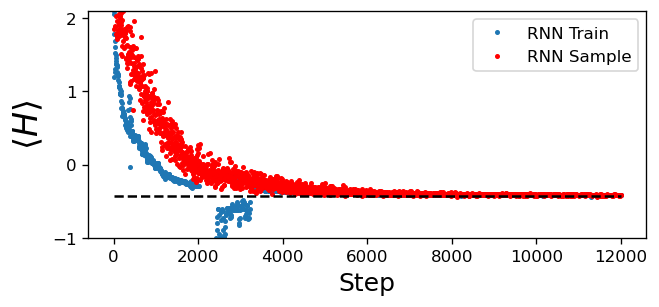

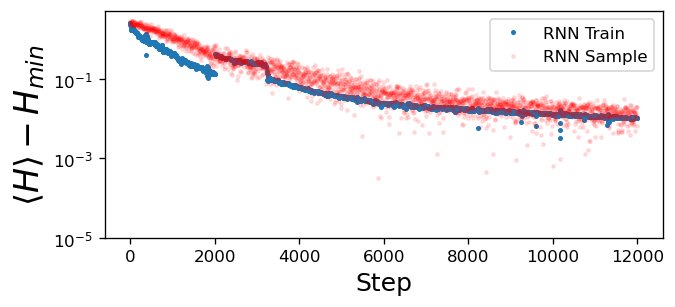

In [15]:

fig = plt.figure(1,figsize=(6,2.5), dpi=120, facecolor='w', edgecolor='k')

plt.plot(losses,marker='o',markersize=2,linewidth=0.0,markevery=5,label="RNN Train")
plt.plot(true_energies,color='r',marker='o',markersize=2,linewidth=0.0,markevery=5,label="RNN Sample")
plt.plot([0,len(losses)],[exact_energy,exact_energy],'k--')

plt.ylim(max(min(losses),-1),max(losses))

plt.xlabel("Step",fontsize=15)
plt.ylabel("$\\langle H \\rangle$",fontsize=20)
plt.legend(loc="best")

plt.show()

fig = plt.figure(1,figsize=(6,2.5), dpi=120, facecolor='w', edgecolor='k')
plt.plot(np.array(losses)-exact_energy,marker='o',markersize=2,linewidth=0.0,markevery=5,label="RNN Train")
plt.plot(np.array(true_energies)-exact_energy,alpha=0.1,color='r',marker='o',markersize=2,linewidth=0.0,markevery=5,label="RNN Sample")
plt.yscale("log")
plt.ylim(1e-5,5)
plt.xlabel("Step",fontsize=15)
plt.ylabel("$\\langle H \\rangle-H_{min}$",fontsize=20)
plt.legend(loc="best")

plt.show()

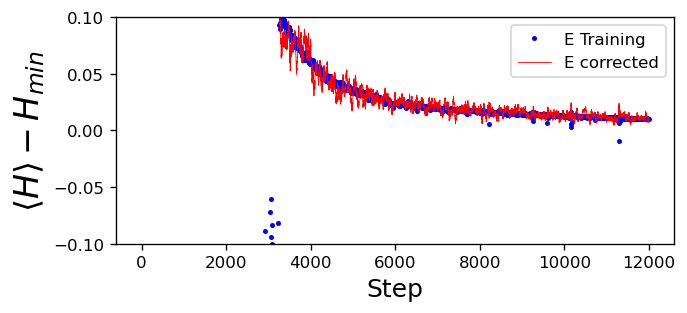

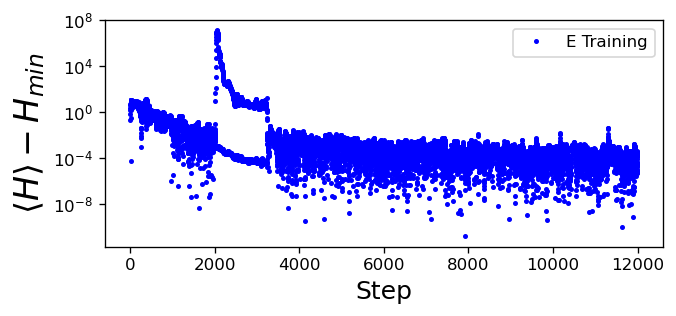

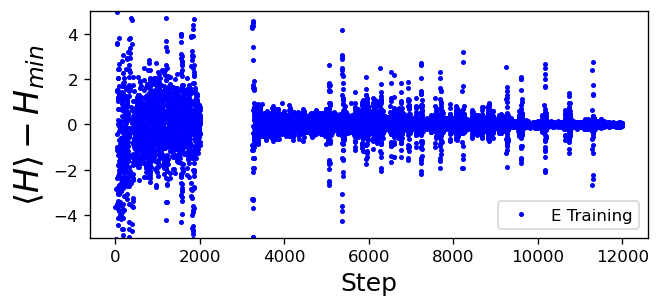

In [16]:
fig = plt.figure(1,figsize=(6,2.5), dpi=120, facecolor='w', edgecolor='k')

plt.plot(np.array(debug)[:,1]-exact_energy,color='b',marker='o',markersize=2,linewidth=0.0,markevery=5,label="E Training")
plt.plot(np.array(debug)[:,0]-exact_energy,"r-",lw=0.5,label="E corrected")
#plt.yscale("log")
#plt.ylim(1e-5,5)
plt.ylim(-0.1,0.1)
plt.xlabel("Step",fontsize=15)
plt.ylabel("$\\langle H \\rangle-H_{min}$",fontsize=20)
plt.legend(loc="best")
plt.show()


fig = plt.figure(1,figsize=(6,2.5), dpi=120, facecolor='w', edgecolor='k')

DEBUG = np.array(debug)

plt.plot((DEBUG[:,1]-DEBUG[:,0])**2*Lx*Ly,color='b',marker='o',markersize=2,linewidth=0.0,label="E Training")
#plt.plot(,"r-",lw=0.5,label="E corrected")
plt.yscale("log")
#plt.ylim(1e-5,5)
plt.xlabel("Step",fontsize=15)
plt.ylabel("$\\langle H \\rangle-H_{min}$",fontsize=20)
plt.legend(loc="best")
plt.show()

fig = plt.figure(1,figsize=(6,2.5), dpi=120, facecolor='w', edgecolor='k')

plt.plot(DEBUG[:,2],color='b',marker='o',markersize=2,linewidth=0.0,label="E Training")
#plt.plot(,"r-",lw=0.5,label="E corrected")
#plt.yscale("log")
plt.ylim(-5,5)
plt.xlabel("Step",fontsize=15)
plt.ylabel("$\\langle H \\rangle-H_{min}$",fontsize=20)
plt.legend(loc="best")
plt.show()

In [17]:
if True:
    print(losses[-1]-exact_energy,losses[-1],true_energies[-1])
    torch.save(trainrnn,"CORR")
    np.savez("CORR",losses,true_energies)

0.010353140830993646 -0.41964685916900635 -0.4170265727572971


In [18]:
if False:
    trainrnn=torch.load("TSTB")
    arrs = np.load("TSTB.npz")
    losses,true_energies = [arrs[a] for a in arrs]

In [19]:
if False:
    bsize=512
    BlockNum=32
    BbyL=bsize//BlockNum

    SQ = torch.zeros([bsize*10,Lx*Ly,1]).to(device)
    SPQ=torch.zeros([bsize*10]).to(device)
    SRPQ=torch.zeros([bsize*10]).to(device)


    for k in range(BlockNum*10):
        sample,sump,sqrtp = trainrnn.sample_with_labelsALT(BbyL,Lx*Ly,grad=False)
        with torch.no_grad():
            SQ[k*BbyL:(k+1)*BbyL]=sample
            SPQ[k*BbyL:(k+1)*BbyL]=sump
            SRPQ[k*BbyL:(k+1)*BbyL]=sqrtp

    with torch.no_grad():
        logp=trainrnn.logprobability(SQ)
        E=h.localenergyALT(SQ,logp,SPQ,SRPQ)
        Eo=E.mean()

    ERR  = Eo/(Lx*Ly)

    print(ERR.detach().item())
    print(torch.var_mean(E/(Lx*Ly)))
    print(exact_energy)

In [20]:
#1/0

# Save and Push

In [ ]:
import IPython
IPython.display.display(IPython.display.Javascript("IPython.notebook.save_notebook()"),include=['application/javascript'])

In [ ]:
import os
os.system("git commit -a -m \"Auto Commit\"")
os.system("git push origin")

In [ ]:
IPython.Application.instance().kernel.do_shutdown(True)

In [ ]:
x=torch.zeros(10)
x.min().item()